In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

pd.set_option('mode.chained_assignment',None)

In [62]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [63]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0, parse_dates = [1])
y = df_full.time_to_reservation
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-8:-1])

## Simple network

In [64]:
df = df_full.drop(columns=['hour_index', 'dist_to_station', 'degree']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df.drop(columns = ['index'], inplace=True)

In [65]:
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.38,1,0.999999,0.001309,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.38,1,0.999994,0.003418,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.32,1,0.999984,0.005600,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.65,1,0.999982,0.006036,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.38,1,0.999950,0.010035,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155841,0.50,0,0.990258,-0.139245,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
155842,0.80,0,0.990629,-0.136580,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155843,0.90,0,0.990797,-0.135355,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [66]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [67]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(264,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,16),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(16,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=264, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
) 18017


In [68]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.543463 , Valid Loss 17.518283 ,Train R2 0.193358, Valid R2 0.190646
Epoch 11: Train Loss 18.171892 , Valid Loss 17.229190 ,Train R2 0.218546, Valid R2 0.204002
Epoch 21: Train Loss 18.044308 , Valid Loss 17.106886 ,Train R2 0.225336, Valid R2 0.209653
Epoch 31: Train Loss 17.977258 , Valid Loss 17.094806 ,Train R2 0.227810, Valid R2 0.210211
EarlyStopping counter: 5 out of 10
Epoch 41: Train Loss 17.913630 , Valid Loss 17.108089 ,Train R2 0.228230, Valid R2 0.209597
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 17.865760 , Valid Loss 17.133767 ,Train R2 0.228689, Valid R2 0.208411
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 53: Train Loss 17.909103 , Valid Loss 17.014872 , Train R2 0.234222, Valid R2 0.213904


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

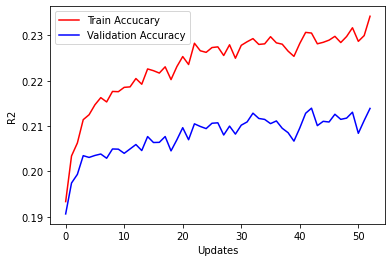

In [69]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

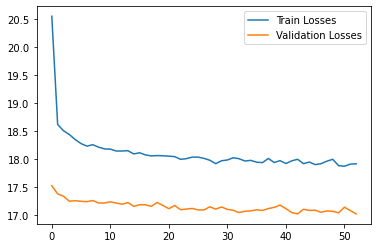

Max Val R2: 0.21395665573228517
Test R2: 0.21107298541388575


In [70]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

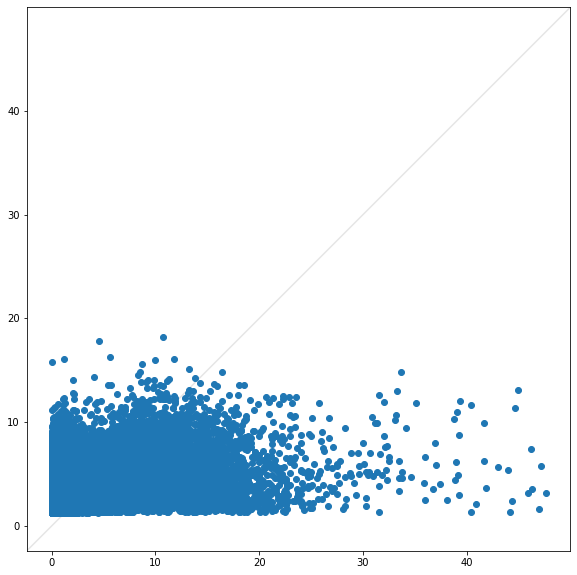

In [71]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.1, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## No Zones

In [12]:
df = df_full.iloc[:,:11]
df.drop(columns = ['degree','index','hour_index'], inplace = True)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,0.38,1,0.999999,0.001309,0,0,1,0
1,0.38,1,0.999994,0.003418,1,0,0,0
2,0.32,1,0.999984,0.005600,0,1,0,0
3,0.65,1,0.999982,0.006036,0,0,1,0
4,0.38,1,0.999950,0.010035,0,0,1,0
...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0
155841,0.50,0,0.990258,-0.139245,0,0,1,0
155842,0.80,0,0.990629,-0.136580,0,0,1,0
155843,0.90,0,0.990797,-0.135355,0,0,1,0


In [13]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [14]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(8,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.0),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.0),
            nn.Linear(128,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
) 35329


In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.01) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.626430 , Valid Loss 19.619396 ,Train R2 0.088814, Valid R2 0.093573
EarlyStopping counter: 5 out of 10
Epoch 11: Train Loss 20.221693 , Valid Loss 19.507589 ,Train R2 0.093611, Valid R2 0.098739
Epoch 21: Train Loss 20.162107 , Valid Loss 19.435141 ,Train R2 0.096843, Valid R2 0.102086
Epoch 31: Train Loss 20.128864 , Valid Loss 19.341391 ,Train R2 0.100716, Valid R2 0.106417
Epoch 41: Train Loss 20.096638 , Valid Loss 19.307236 ,Train R2 0.102257, Valid R2 0.107995
Epoch 51: Train Loss 20.086285 , Valid Loss 19.275477 ,Train R2 0.103503, Valid R2 0.109463
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 20.068701 , Valid Loss 19.267610 ,Train R2 0.104045, Valid R2 0.109826
EarlyStopping counter: 5 out of 10
Epoch 71: Train Loss 20.052641 , Valid Loss 19.259331 ,Train R2 0.104448, Valid R2 0.110209
EarlyStopping counter: 5 out of 10
Epoch 81: Train Loss 20.042394 , Valid Loss 19.392503 ,Train R2 0.098865, Valid R2 0.104056
Epoch 91: Train Loss 20.041722 ,

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

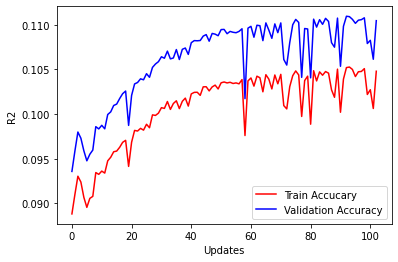

In [16]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

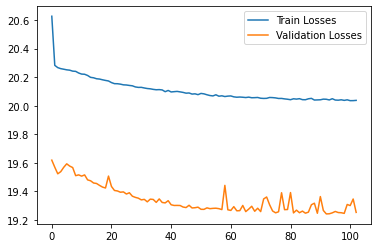

Max Val R2: 0.11095786427860888
Test R2: 0.10857225091894451


In [17]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

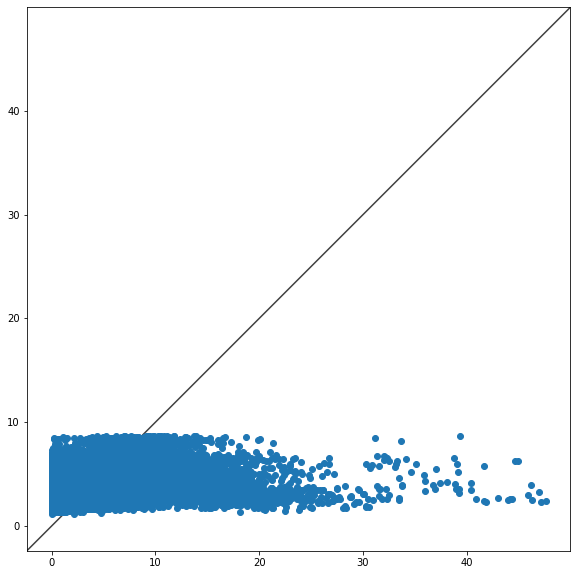

In [18]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Embedding

In [19]:
df = df_full.drop(columns=['dist_to_station', 'degree', 'index', 'hour_index']+weather_var, inplace = False)
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,Zone
0,0.38,1,0.999999,0.001309,0,0,1,0,62
1,0.38,1,0.999994,0.003418,1,0,0,0,138
2,0.32,1,0.999984,0.005600,0,1,0,0,95
3,0.65,1,0.999982,0.006036,0,0,1,0,113
4,0.38,1,0.999950,0.010035,0,0,1,0,14
...,...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0,54
155841,0.50,0,0.990258,-0.139245,0,0,1,0,250
155842,0.80,0,0.990629,-0.136580,0,0,1,0,183
155843,0.90,0,0.990797,-0.135355,0,0,1,0,249


In [20]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [21]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(256,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(8+emb_dim,256),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(32)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 4)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(256, 4)
  (seq): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 45569


In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.0005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 21.236650 , Valid Loss 18.407157 ,Train R2 0.147602, Valid R2 0.149579
Epoch 11: Train Loss 17.948204 , Valid Loss 17.334431 ,Train R2 0.215087, Valid R2 0.199140
Epoch 21: Train Loss 17.664964 , Valid Loss 17.199000 ,Train R2 0.226889, Valid R2 0.205397
Epoch 31: Train Loss 17.507406 , Valid Loss 17.121672 ,Train R2 0.237265, Valid R2 0.208970
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 39: Train Loss 17.435548 , Valid Loss 17.137715 , Train R2 0.239765, Valid R2 0.208228


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

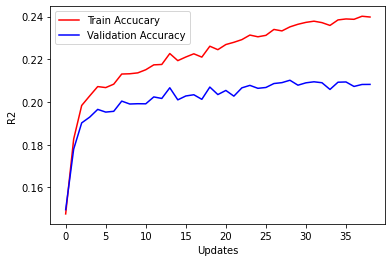

In [23]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

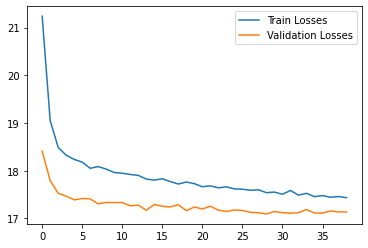

Max Val R2: 0.21017259349872774
Test R2: 0.2086478750581423


In [24]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

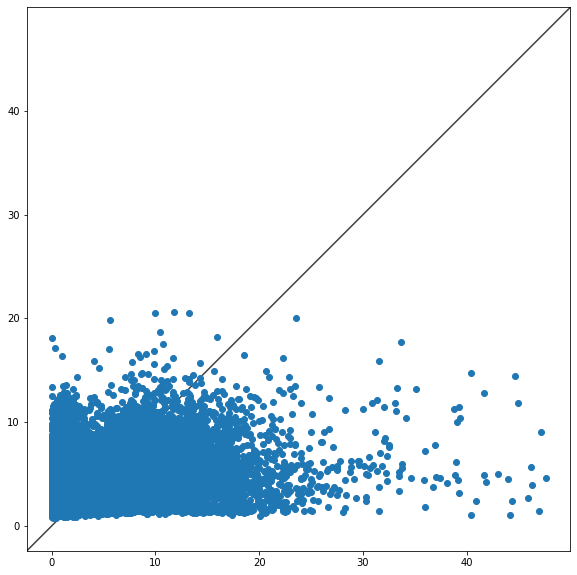

In [25]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Degree

In [26]:
df = df_full.drop(columns=['dist_to_station', 'index', 'hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [27]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [28]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            #nn.Linear(64,64),
            #nn.ReLU(),#nn.BatchNorm1d(128)),
            #nn.Dropout(0.2),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
) 42369


In [29]:
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.194744 , Valid Loss 16.988707 ,Train R2 0.222255, Valid R2 0.215113
Epoch 11: Train Loss 16.923852 , Valid Loss 16.650613 ,Train R2 0.269946, Valid R2 0.230733
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 16.682212 , Valid Loss 16.639653 ,Train R2 0.282784, Valid R2 0.231239
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 30: Train Loss 16.598388 , Valid Loss 16.741273 , Train R2 0.290244, Valid R2 0.226544


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

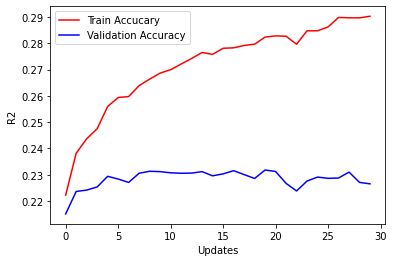

In [30]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

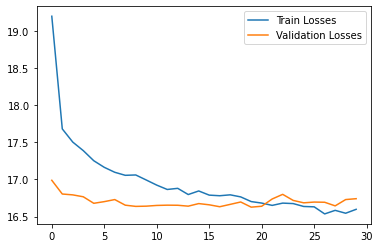

Max Val R2: 0.23180124364726207
Test R2: 0.22714083593068968


In [31]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

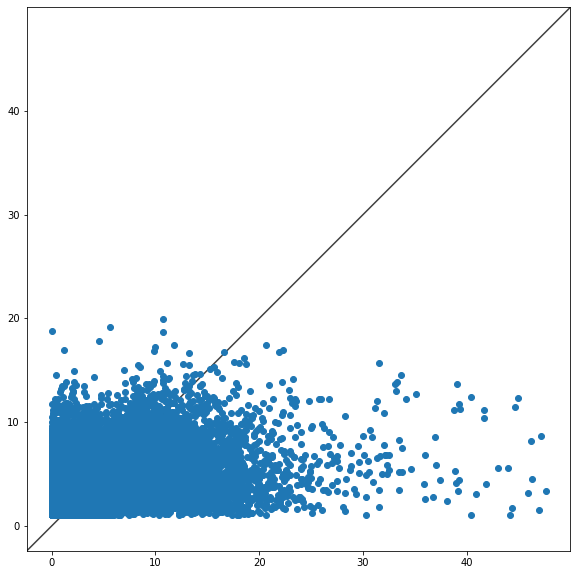

In [32]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Dist to Station

In [33]:
df = df_full.drop(columns=['degree', 'index', 'hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,0.38,1,0.999999,0.001309,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.056678
1,0.38,1,0.999994,0.003418,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.256871
2,0.32,1,0.999984,0.005600,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.100475
3,0.65,1,0.999982,0.006036,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.083079
4,0.38,1,0.999950,0.010035,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.074560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,0,0.988865,-0.148816,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.018069
155841,0.50,0,0.990258,-0.139245,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0.160231
155842,0.80,0,0.990629,-0.136580,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.047165
155843,0.90,0,0.990797,-0.135355,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0.146090


In [34]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz|weekend')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz|weekend')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$')-test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng|weekend)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz|weekend')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [35]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(265,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(64,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.2),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=265, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 25409


In [36]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.095322 , Valid Loss 17.397124 ,Train R2 0.200184, Valid R2 0.196244
Epoch 11: Train Loss 17.193133 , Valid Loss 16.910914 ,Train R2 0.259875, Valid R2 0.218707
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 18: Train Loss 16.992368 , Valid Loss 16.901181 , Train R2 0.272641, Valid R2 0.219156


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

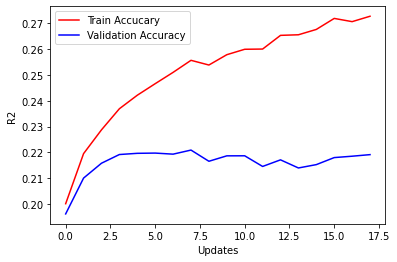

In [37]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

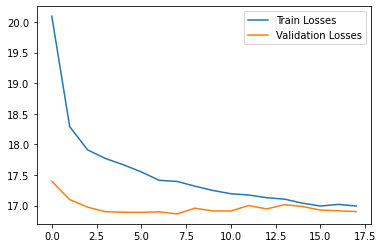

Max Val R2: 0.22091873608423784
Test R2: 0.21428241819028682


In [38]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

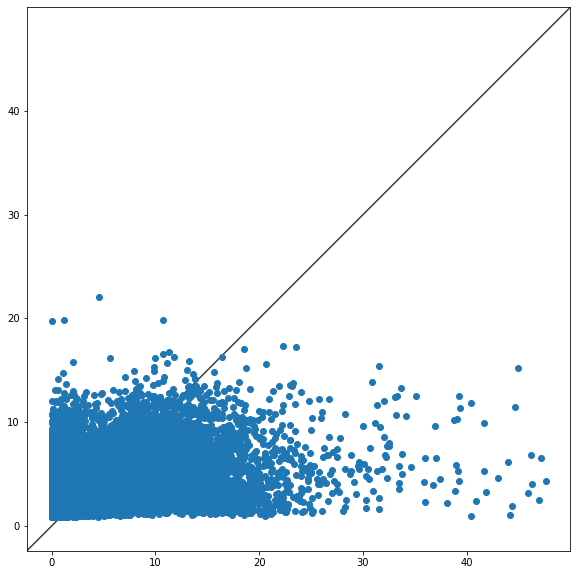

In [39]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Both

In [40]:
df = df_full.drop(columns=['index','hour_index']+weather_var, inplace = False)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203,dist_to_station
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.056678
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.256871
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.100475
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.083079
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.074560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.018069
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0.160231
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0.047165
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0.146090


In [41]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [42]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(266,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(128,32),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.2),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=266, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
) 38337


In [43]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.0001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 20.017054 , Valid Loss 17.172764 ,Train R2 0.210354, Valid R2 0.206609
Epoch 11: Train Loss 16.732011 , Valid Loss 16.475340 ,Train R2 0.284813, Valid R2 0.238830
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 18: Train Loss 16.349084 , Valid Loss 16.545473 , Train R2 0.302006, Valid R2 0.235590


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

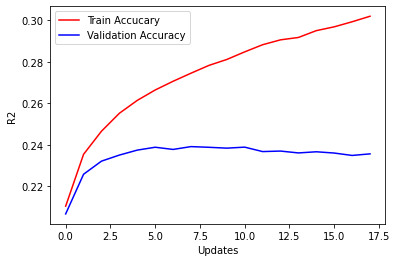

In [44]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

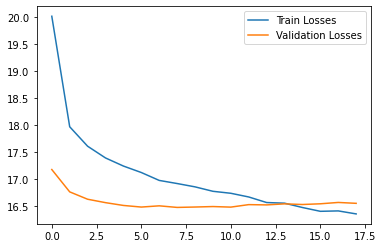

Max Val R2: 0.23909217090135648
Test R2: 0.23521687254230172


In [45]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

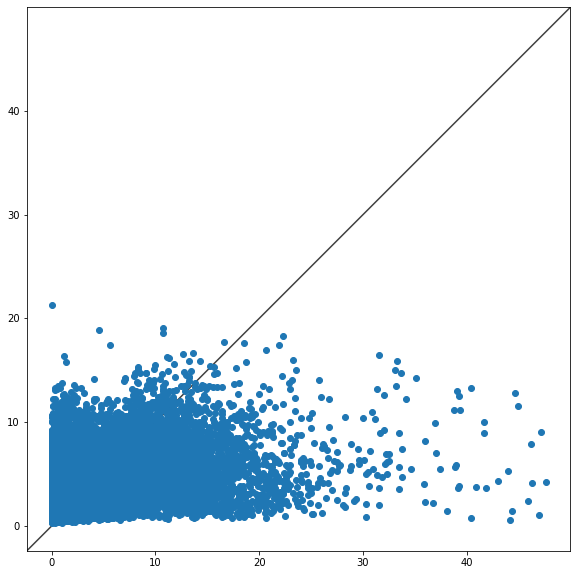

In [46]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Weather

In [47]:
df = df_full.drop(['index','hour_index'],axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,0,...,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.056678
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,0,...,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.256871
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,0,...,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.100475
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,0,...,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.083079
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,0,...,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.074560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,0,...,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.018069
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,0,...,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.160231
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,0,...,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.047165
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,0,...,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.146090


In [48]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state = 1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state = 2)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

minmax = True
if minmax:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]), (train_data[weather_var[:7]]-train_data[weather_var[:7]].min())/(train_data[weather_var[:7]].max()-train_data[weather_var[:7]].min())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]), (val_data[weather_var[:7]]-val_data[weather_var[:7]].min())/(val_data[weather_var[:7]].max()-val_data[weather_var[:7]].min())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]), (test_data[weather_var[:7]]-test_data[weather_var[:7]].min())/(test_data[weather_var[:7]].max()-test_data[weather_var[:7]].min())], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]), (train_data[weather_var[:7]]-train_data[weather_var[:7]].mean())/(train_data[weather_var[:7]].std())], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]), (val_data[weather_var[:7]]-val_data[weather_var[:7]].mean())/(val_data[weather_var[:7]].std())], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]), (test_data[weather_var[:7]]-test_data[weather_var[:7]].mean())/(test_data[weather_var[:7]].std())], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [49]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(273,256),
            nn.ReLU(),#nn.BatchNorm1d(256)),
            nn.Dropout(0.15),
            nn.Linear(256,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.15),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.15),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=273, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.15, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.15, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.15, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 111361


In [50]:
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001)
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.358112 , Valid Loss 17.787784 ,Train R2 0.179927, Valid R2 0.178195
Epoch 11: Train Loss 15.331413 , Valid Loss 16.448966 ,Train R2 0.315133, Valid R2 0.240049
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 17: Train Loss 14.488684 , Valid Loss 16.705423 , Train R2 0.352778, Valid R2 0.228200


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

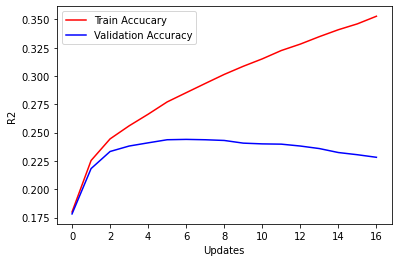

In [51]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

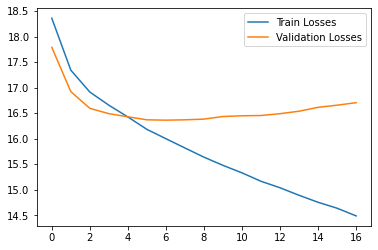

Max Val R2: 0.24401512672414338
Test R2: 0.22325509407244226


In [52]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

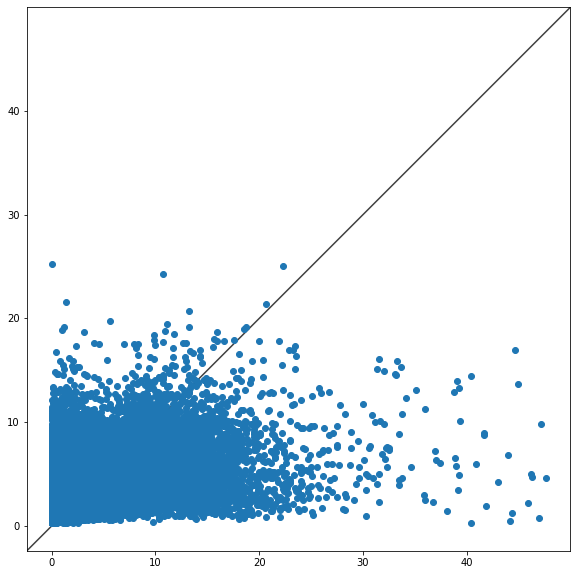

In [53]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

## With Weather and Embedding

In [54]:
df = df_full.drop(columns = ['hour_index', 'index'])
df['Zone'] = df.filter(regex = 'lz').values.argmax(1)
df = df.drop(df.filter(regex='lz').columns,axis=1)
df['leave_fuel'] = df['leave_fuel']/100
df['dist_to_station'] = df['dist_to_station']/5320
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station,Zone
0,0.38,26.186523,1,0.999999,0.001309,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.056678,62
1,0.38,11.476456,1,0.999994,0.003418,1,0,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.256871,138
2,0.32,2.159959,1,0.999984,0.005600,0,1,0,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.100475,95
3,0.65,3.701779,1,0.999982,0.006036,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.083079,113
4,0.38,10.134994,1,0.999950,0.010035,0,0,1,0,22.4,3.6,2.4,0.0,1010.4,80.0,87.0,0.074560,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155840,0.82,20.815263,0,0.988865,-0.148816,1,0,0,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.018069,54
155841,0.50,6.382984,0,0.990258,-0.139245,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.160231,250
155842,0.80,8.983153,0,0.990629,-0.136580,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.047165,183
155843,0.90,7.502488,0,0.990797,-0.135355,0,0,1,0,6.6,2.1,0.0,0.0,1023.6,81.5,92.0,0.146090,249


In [55]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data), random_state=2)

train_data['degree'] = (train_data['degree']-1)/(train_data['degree'].max()-1)
val_data['degree'] = (val_data['degree']-1)/(val_data['degree'].max()-1)
test_data['degree'] = (test_data['degree']-1)/(test_data['degree'].max()-1)

minmax = False
if minmax:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]+['Zone']), (train_data[weather_var[:7]]-train_data[weather_var[:7]].min())/(train_data[weather_var[:7]].max()-train_data[weather_var[:7]].min()),train_data.Zone], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]+['Zone']), (val_data[weather_var[:7]]-val_data[weather_var[:7]].min())/(val_data[weather_var[:7]].max()-val_data[weather_var[:7]].min()),val_data.Zone], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]+['Zone']), (test_data[weather_var[:7]]-test_data[weather_var[:7]].min())/(test_data[weather_var[:7]].max()-test_data[weather_var[:7]].min()),test_data.Zone], axis = 1)
else:
    train_data = pd.concat([train_data.drop(columns = weather_var[:7]+['Zone']), (train_data[weather_var[:7]]-train_data[weather_var[:7]].mean())/(train_data[weather_var[:7]].std()),train_data.Zone], axis = 1)
    val_data = pd.concat([val_data.drop(columns = weather_var[:7]+['Zone']), (val_data[weather_var[:7]]-val_data[weather_var[:7]].mean())/(val_data[weather_var[:7]].std()),val_data.Zone], axis = 1)
    test_data = pd.concat([test_data.drop(columns = weather_var[:7]+['Zone']), (test_data[weather_var[:7]]-test_data[weather_var[:7]].mean())/(test_data[weather_var[:7]].std()),test_data.Zone], axis = 1)
    
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [56]:
# define network
class Net(nn.Module):

    def __init__(self, emb_dim):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding(256,emb_dim)

        self.seq = nn.Sequential(
            nn.Linear(17+emb_dim,128),
            nn.ReLU(),#nn.BatchNorm1d(128)),
            nn.Dropout(0.1),
            nn.Linear(128,64),
            nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.1),
            #nn.Linear(128,64),
            #nn.ReLU(),#nn.BatchNorm1d(64)),
            nn.Dropout(0.15),
            nn.Linear(64,1)
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x_emb_in = x[:,-1].long()
        x_emb_out = self.embedding(x_emb_in)
        x = torch.cat([x[:,:-1],x_emb_out], axis = 1)
        x = self.seq(x)
        return x


net = Net(emb_dim = 8)
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (embedding): Embedding(256, 8)
  (seq): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Dropout(p=0.15, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
) 13697


In [57]:
optimizer = optim.Adam(net.parameters(), lr=0.002, weight_decay = 0.00005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.809489 , Valid Loss 19.103992 ,Train R2 0.115093, Valid R2 0.117385
Epoch 11: Train Loss 16.936132 , Valid Loss 16.664508 ,Train R2 0.243448, Valid R2 0.230091
Epoch 21: Train Loss 16.464408 , Valid Loss 16.436672 ,Train R2 0.264521, Valid R2 0.240617
Epoch 31: Train Loss 16.118434 , Valid Loss 16.392698 ,Train R2 0.279976, Valid R2 0.242649
Epoch 41: Train Loss 15.804505 , Valid Loss 16.372982 ,Train R2 0.293999, Valid R2 0.243559
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 5 out of 10
Epoch 51: Train Loss 15.505996 , Valid Loss 16.349028 ,Train R2 0.307334, Valid R2 0.244666
EarlyStopping counter: 5 out of 10
Epoch 61: Train Loss 15.264593 , Valid Loss 16.370989 ,Train R2 0.318118, Valid R2 0.243652
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 63: Train Loss 15.206145 , Valid Loss 16.383120 , Train R2 0.320728, Valid R2 0.243091


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

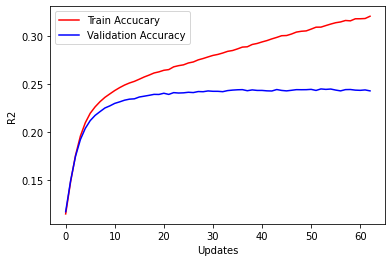

In [58]:
# setting hyperparameters and gettings epoch sizes
batch_size = 1024
num_epochs = 301
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

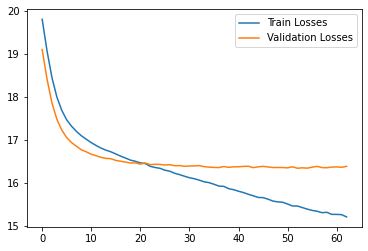

Max Val R2: 0.24510920565173555
Test R2: 0.23698559037656108


In [59]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(f'Max Val R2: {max(valid_r2)}')
print(f'Test R2: {r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])}')

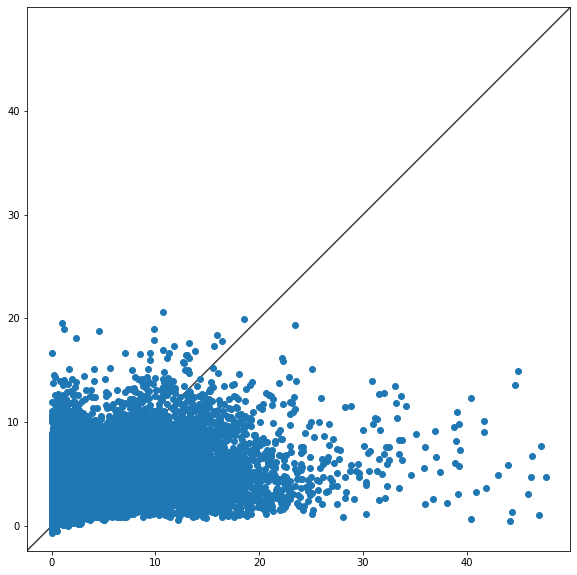

In [60]:
fig, ax = plt.subplots(figsize = (16,10))

ax.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()